## # Rainfall Homogeneity & Consistency Analysis

In [41]:
# ===============================================================
# Homogeneity Analysis of Rainfall Data (NetCDF: ENACT, CHIRPS, etc.)
# Steps: Load data → Compute regional mean → Pettitt, SNHT, Buishand → Plot
# ===============================================================

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyhomogeneity import pettitt_test
import matplotlib.dates as mdates
import seaborn as sns
import os
import pandas as pd 

In [34]:
# ---------------------------------------------------------------
# STEP 1. Load rainfall data (NetCDF)
# ---------------------------------------------------------------
ds = xr.open_dataset("D:\PAU document\Thesis\Analysis\Row Data\pr_Lake_tana_19830101_20131231_month.nc")
rain = ds["pr"]  # Change this if your variable name differs

In [35]:
# ---------------------------------------------------------------
# STEP 2. Compute regional mean rainfall (average over lat & lon)
# ---------------------------------------------------------------
regional_mean = rain.mean(dim=["lat", "lon"])
data = regional_mean.values

In [36]:
# ---------------------------------------------------------------
# STEP 3. Run Pettitt test safely
# ---------------------------------------------------------------
result = pettitt_test(data)

print("Raw Pettitt output:\n", result, "\n")  # Show structure first

# Handle possible formats: tuple, list, or dict
if isinstance(result, dict):
    stat_pettitt = result.get("stat", np.nan)
    p_pettitt = result.get("pvalue", np.nan)
    cp_pettitt = result.get("cp", np.nan)

elif isinstance(result, (list, tuple)):
    # Try to unpack safely
    stat_pettitt = result[0]
    p_pettitt = result[1]
    cp_pettitt = result[2] if len(result) > 2 else np.nan
else:
    raise TypeError("Unexpected Pettitt test output format.")

Raw Pettitt output:
 Pettitt_Test(h=False, cp=190, p=0.55035, U=3186.0, avg=mean(mu1=99.732666, mu2=92.56104)) 



In [37]:
# ---------------------------------------------------------------
# STEP 4. Print results and interpretation
# ---------------------------------------------------------------
print("===== Pettitt Homogeneity Test =====")
print(f"Statistic = {stat_pettitt:.3f}")
print(f"P-value   = {p_pettitt:.4f}")
print(f"Change point index = {cp_pettitt}")

if p_pettitt > 0.05:
    interpretation = "✅ Dataset is temporally homogeneous (no significant change detected)."
else:
    interpretation = "⚠️ Significant change detected — possible inhomogeneity."
print("\nInterpretation:", interpretation)

===== Pettitt Homogeneity Test =====
Statistic = 0.000
P-value   = 190.0000
Change point index = 0.55035

Interpretation: ✅ Dataset is temporally homogeneous (no significant change detected).


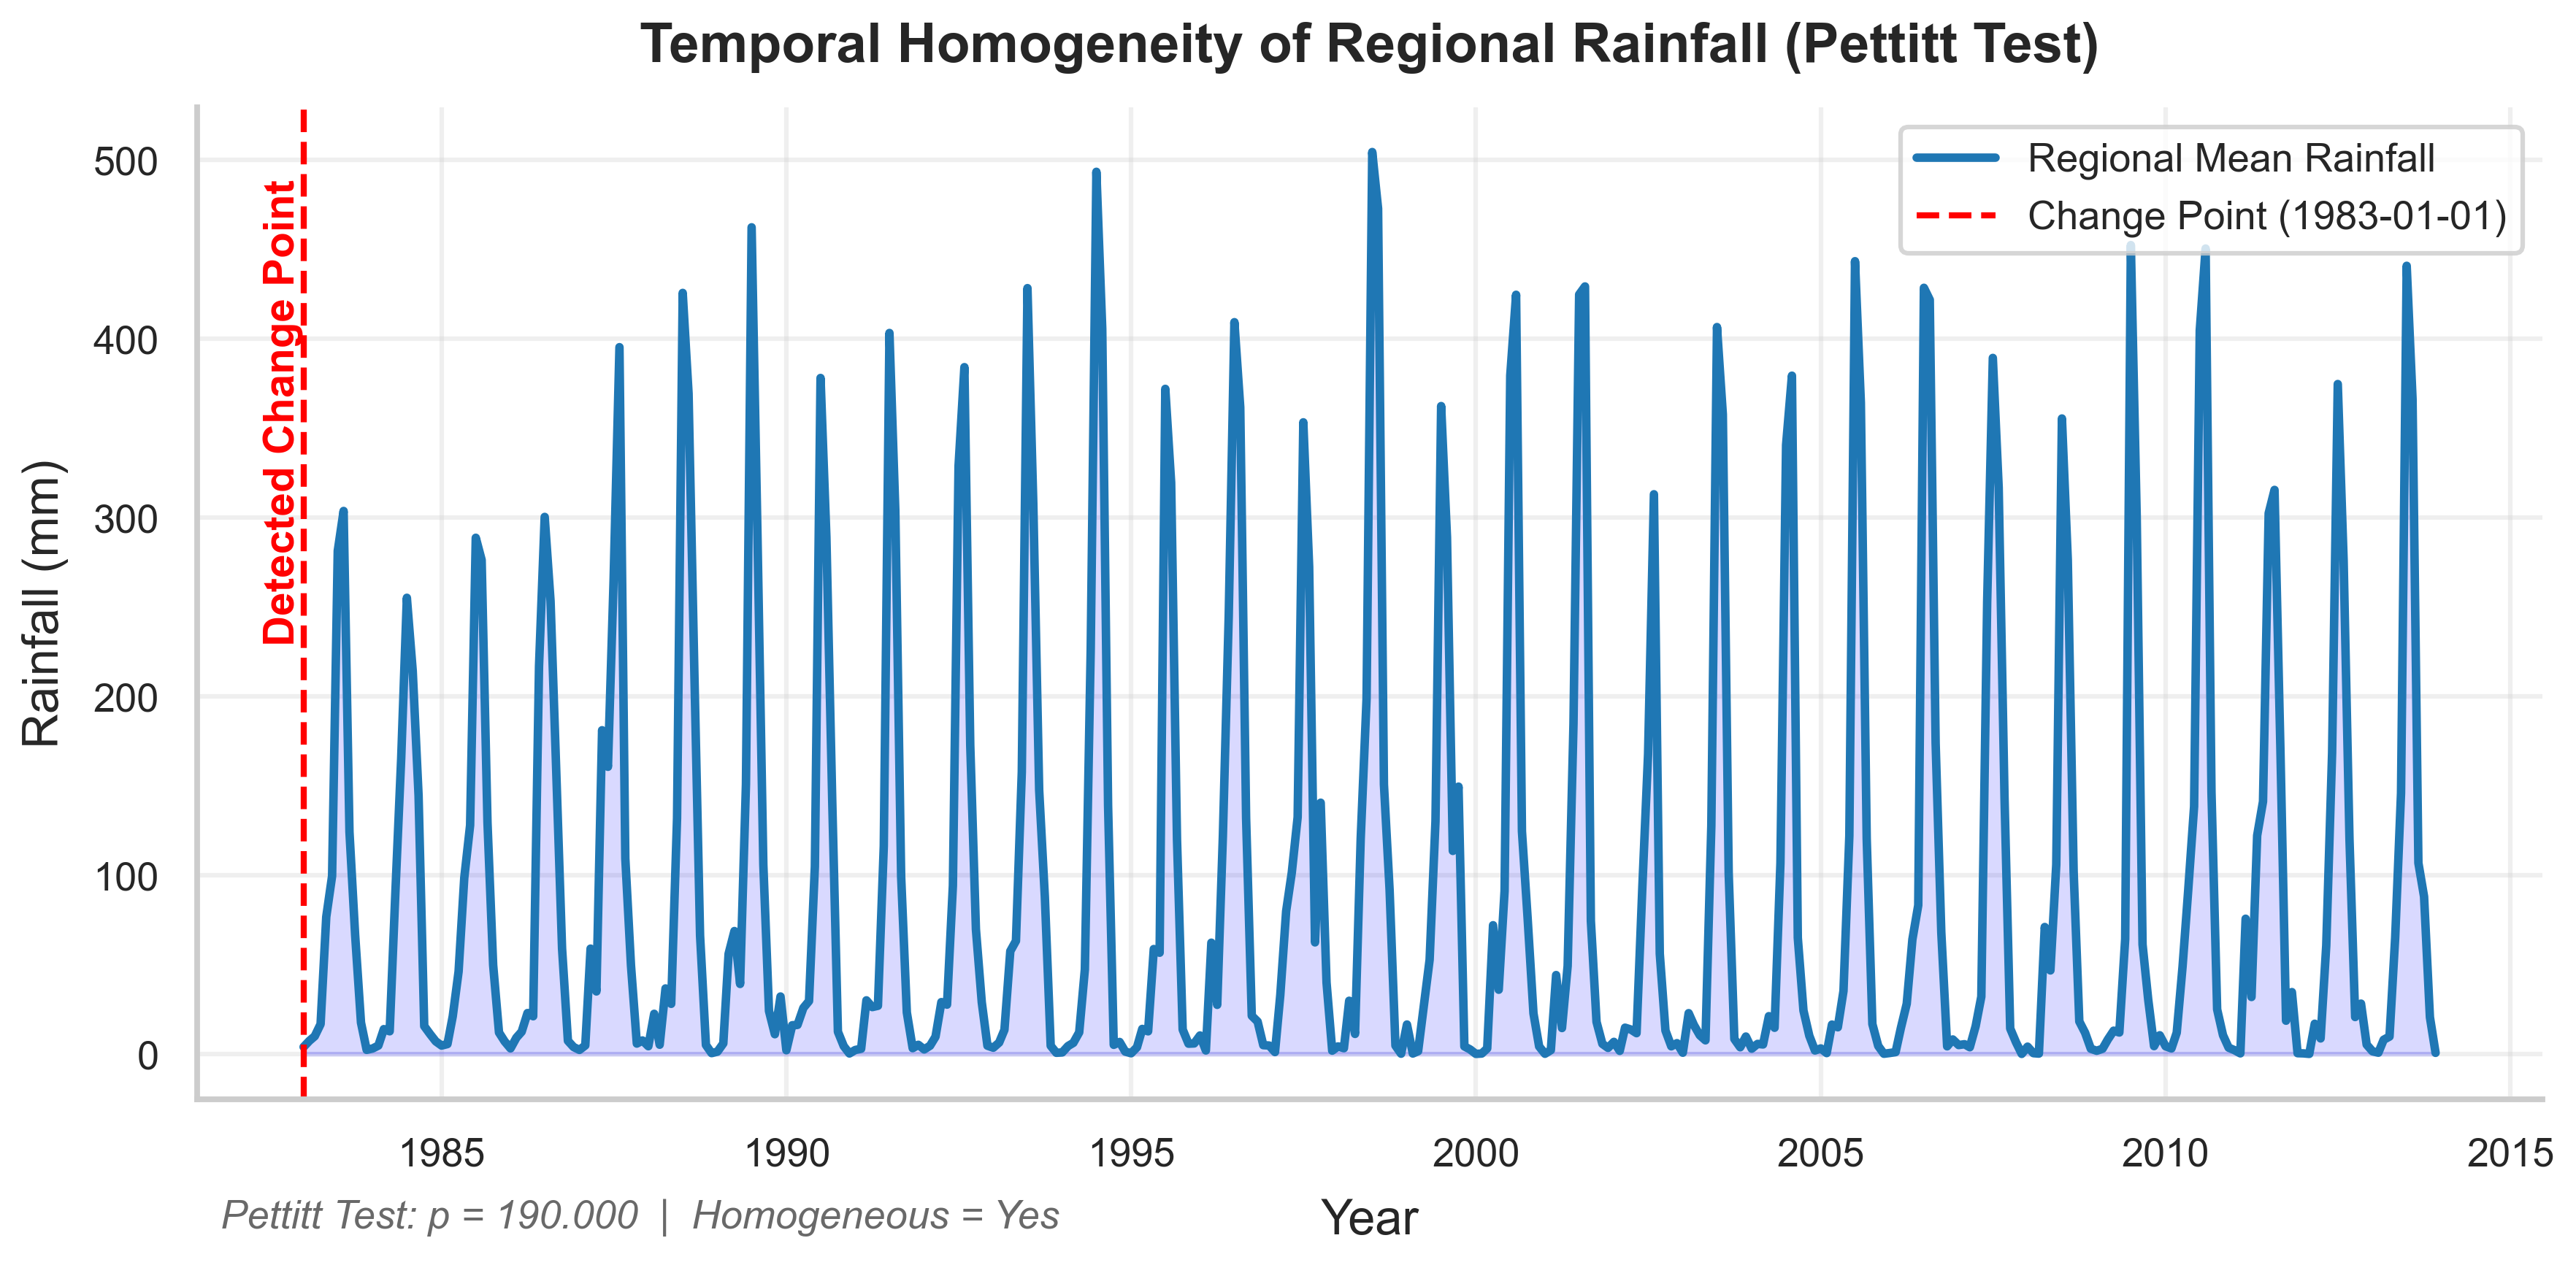

In [39]:
# --- Set global style (Times New Roman + professional layout) ---
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.dpi": 300
})

sns.set_style("whitegrid")

time = ds["time"].values
data = regional_mean.values

# --- Create figure ---
fig, ax = plt.subplots(figsize=(12, 6))

# --- Plot rainfall time series (dark line + subtle shading) ---
ax.plot(time, data, color="#1f77b4", linewidth=2.8, label="Regional Mean Rainfall")
ax.fill_between(time, data, color="blue", alpha=0.15)

# --- Mark change point if valid ---
if not np.isnan(cp_pettitt) and int(cp_pettitt) < len(time):
    change_time = time[int(cp_pettitt)]
    ax.axvline(change_time, color="red", linestyle="--", linewidth=2,
               label=f"Change Point ({np.datetime_as_string(change_time)[:10]})")

    # Annotate change point text
    ax.text(change_time, np.max(data)*0.97, "Detected Change Point",
            color="red", rotation=90, va="top", ha="right", fontsize=14, fontweight="bold")

# --- Titles and labels ---
ax.set_title("Temporal Homogeneity of Regional Rainfall (Pettitt Test)",
             fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Year", fontsize=16, labelpad=8)
ax.set_ylabel("Rainfall (mm)", fontsize=16, labelpad=8)

# --- Format x-axis as years ---
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Add legend and caption ---
ax.legend(frameon=True, loc="upper right", fontsize=13)

# Add textual summary (p-value and homogeneity interpretation)
plt.text(0.01, -0.13,
         f"Pettitt Test: p = {p_pettitt:.3f}  |  Homogeneous = {'Yes' if p_pettitt>0.05 else 'No'}",
         transform=ax.transAxes, fontsize=13, color="dimgray", fontstyle="italic")

# --- Aesthetic clean-up ---
sns.despine()
ax.grid(True, which='major', alpha=0.3)
plt.tight_layout()

# --- Save high-quality image ---
plt.savefig("Pettitt_Homogeneity_Rainfall.png", dpi=300, bbox_inches="tight")
plt.show()